<a href="https://colab.research.google.com/github/munikumar229/es335-24-fall-assignment-2/blob/master/Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task 4 : Image Reconstruction using Matrix Factorisation [4 Marks]

1.  Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank
r. Run Gradient Descent until it converges, plot the reconstructed image alongside the original image. Calculate and report the RMSE and PSNR metrics. [1 Marks]

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.metrics import mean_squared_error
from math import log10, sqrt

(1919, 1920, 3)


(300, 300, 3)

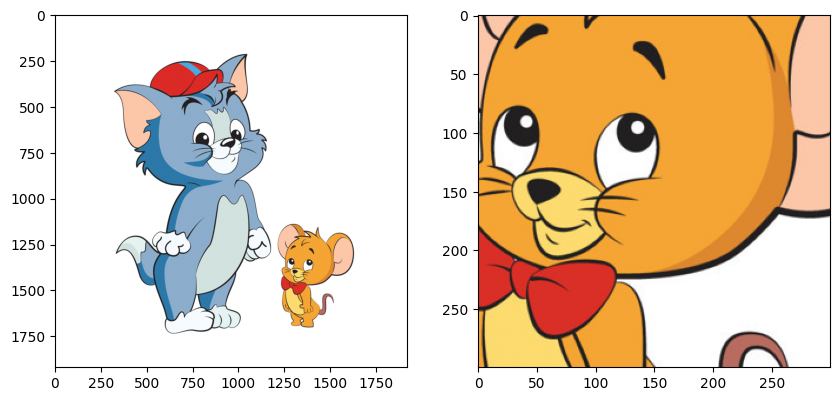

In [ ]:
# Load the RGB image
image_org = io.imread('/content/tom-and-jerry-cartoon.jpg')
image = image_org / 255.0  # Normalize pixel values to [0, 1]
print(image.shape)

crop = image[1250:1550, 1250:1550]  # Crop to min_dim x min_dim
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(crop)

crop.shape

In [ ]:
# Function to randomly mask 30% of the pixels
def mask_random_pixels(channel, mask_ratio):
    mask = torch.ones_like(channel, dtype=torch.float32)
    num_pixels = int(mask_ratio * channel.numel())
    mask = mask.view(-1)
    missing_indices = torch.randperm(mask.size(0))[:num_pixels]
    mask[missing_indices] = 0  # Set 30% of pixels to 0 (mask them)
    mask = mask.view(channel.size())

    masked_channel = channel.clone()
    masked_channel[mask == 0] = float('nan')  # Set masked values to NaN for matrix factorization
    return masked_channel, mask

In [ ]:
# Stack masked channels for visualization

class MatrixFactorization(nn.Module):
    def __init__(self, num_features, rank):
        super(MatrixFactorization, self).__init__()
        self.W = nn.Parameter(torch.randn(num_features, rank))
        self.H = nn.Parameter(torch.randn(rank, num_features))

    def forward(self):
        return torch.mm(self.W, self.H)

In [ ]:
# Consolidated function to mask and reconstruct all three channels
def process_channels(image, mask_ratio, rank, num_epochs=2000, lr=0.01):
    channels = [torch.tensor(image[:, :, i], dtype=torch.float32) for i in range(3)]
    masked_channels = []
    masks = []
    reconstructions = []

    # Mask and reconstruct each channel
    for channel in channels:
        masked_channel, mask = mask_random_pixels(channel, mask_ratio)
        masked_channels.append(masked_channel)
        masks.append(mask)

        # Reconstruct the masked channel
        num_features = channel.shape[0]
        model = MatrixFactorization(num_features, rank)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        mask_tensor = ~torch.isnan(masked_channel)  # Mask for non-missing values

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            reconstructed = model()
            loss = criterion(reconstructed[mask_tensor], masked_channel[mask_tensor])  # Apply mask to both reconstructed and original
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

        reconstructions.append(reconstructed.detach().numpy())

    # Stack reconstructed channels to form the final image
    reconstructed_image = np.stack(reconstructions, axis=2)

    # For plotting, replace NaN with 0 in masked channels
    plot_channels = []
    for masked_channel in masked_channels:
        plot_channel = masked_channel.clone()
        plot_channel[torch.isnan(plot_channel)] = 0
        plot_channels.append(plot_channel.numpy())

    masked_image = np.stack(plot_channels, axis=2)

    return reconstructed_image, masked_image

In [ ]:
# Example usage
rank = 100  # Choose a suitable rank
reconstructed_image, masked_image = process_channels(crop, 0.3, rank)

Epoch [0/2000], Loss: 100.337852
Epoch [100/2000], Loss: 3.794020
Epoch [200/2000], Loss: 0.416264
Epoch [300/2000], Loss: 0.100985
Epoch [400/2000], Loss: 0.045409
Epoch [500/2000], Loss: 0.031081
Epoch [600/2000], Loss: 0.026055
Epoch [700/2000], Loss: 0.023469
Epoch [800/2000], Loss: 0.021543
Epoch [900/2000], Loss: 0.019833
Epoch [1000/2000], Loss: 0.018285
Epoch [1100/2000], Loss: 0.016939
Epoch [1200/2000], Loss: 0.015817
Epoch [1300/2000], Loss: 0.014881
Epoch [1400/2000], Loss: 0.014082
Epoch [1500/2000], Loss: 0.013385
Epoch [1600/2000], Loss: 0.012770
Epoch [1700/2000], Loss: 0.012218
Epoch [1800/2000], Loss: 0.011715
Epoch [1900/2000], Loss: 0.011251
Epoch [0/2000], Loss: 98.660324
Epoch [100/2000], Loss: 3.599255
Epoch [200/2000], Loss: 0.416824
Epoch [300/2000], Loss: 0.102362
Epoch [400/2000], Loss: 0.045241
Epoch [500/2000], Loss: 0.029652
Epoch [600/2000], Loss: 0.023101
Epoch [700/2000], Loss: 0.019392
Epoch [800/2000], Loss: 0.017181
Epoch [900/2000], Loss: 0.015684
E

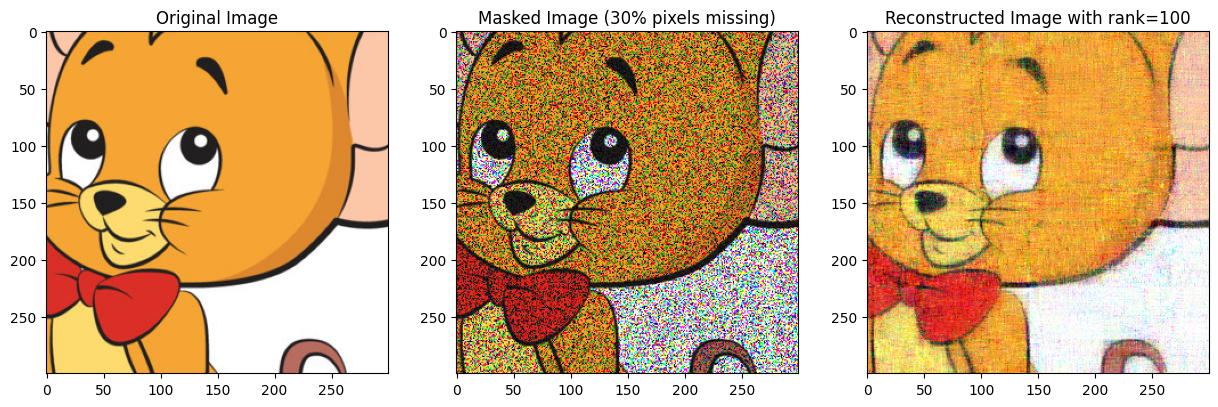

In [ ]:
# Plot the original, masked, and reconstructed images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(crop)
ax[0].set_title('Original Image')

ax[1].imshow(masked_image)
ax[1].set_title('Masked Image (30% pixels missing)')

ax[2].imshow(reconstructed_image)
ax[2].set_title(f'Reconstructed Image with rank={rank}')

plt.show()

In [ ]:
def compute_rmse(original, reconstructed):
    # if mask is not None:
    #     # Apply mask to exclude masked regions from RMSE calculation
    #     original = original[mask]
    #     reconstructed = reconstructed[mask]
    mse = np.mean((original - reconstructed) ** 2)
    rmse = sqrt(mse)
    return rmse

def compute_psnr(original, reconstructed):
    rmse = compute_rmse(original, reconstructed)
    if rmse == 0:
        return float('inf')  # Perfect reconstruction
    psnr = 20 * log10(1 / rmse)
    return psnr

In [ ]:
# Compute RMSE and PSNR for the entire image
rmse = compute_rmse(crop, reconstructed_image)
psnr = compute_psnr(crop, reconstructed_image)

print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.2f} dB")

RMSE: 0.1241
PSNR: 18.12 dB


2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.[3 Marks]

In [ ]:
reconstructed_image_mf, masked_image_900 = process_channels(crop, 0.004, rank)

Epoch [0/2000], Loss: 102.502266
Epoch [100/2000], Loss: 3.822788
Epoch [200/2000], Loss: 0.234469
Epoch [300/2000], Loss: 0.054526
Epoch [400/2000], Loss: 0.035119
Epoch [500/2000], Loss: 0.030324
Epoch [600/2000], Loss: 0.027664
Epoch [700/2000], Loss: 0.025338
Epoch [800/2000], Loss: 0.023344
Epoch [900/2000], Loss: 0.021796
Epoch [1000/2000], Loss: 0.020600
Epoch [1100/2000], Loss: 0.019607
Epoch [1200/2000], Loss: 0.018734
Epoch [1300/2000], Loss: 0.017942
Epoch [1400/2000], Loss: 0.017215
Epoch [1500/2000], Loss: 0.016540
Epoch [1600/2000], Loss: 0.015910
Epoch [1700/2000], Loss: 0.015319
Epoch [1800/2000], Loss: 0.014763
Epoch [1900/2000], Loss: 0.014236
Epoch [0/2000], Loss: 101.667160
Epoch [100/2000], Loss: 3.764173
Epoch [200/2000], Loss: 0.242591
Epoch [300/2000], Loss: 0.055441
Epoch [400/2000], Loss: 0.034479
Epoch [500/2000], Loss: 0.027016
Epoch [600/2000], Loss: 0.022519
Epoch [700/2000], Loss: 0.020137
Epoch [800/2000], Loss: 0.018462
Epoch [900/2000], Loss: 0.016856


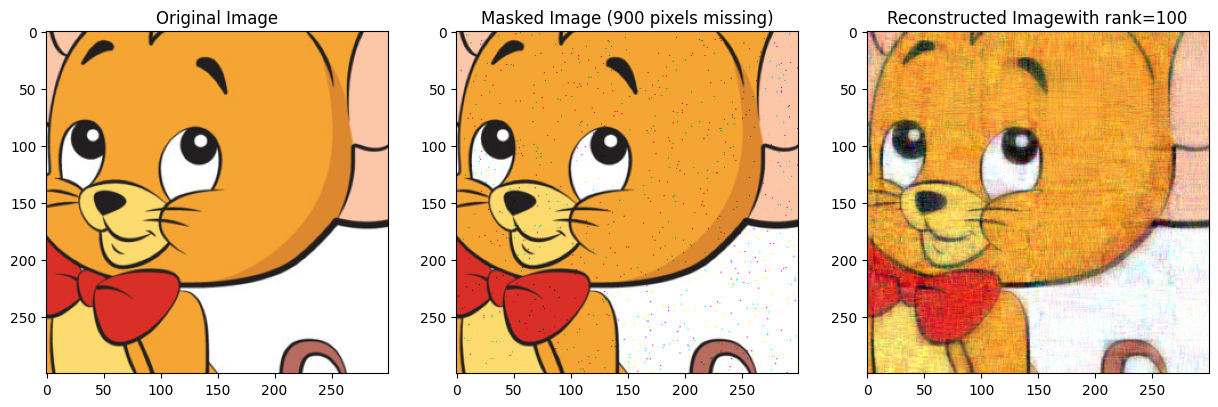

In [ ]:
# Plot the original, masked, and reconstructed images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(crop)
ax[0].set_title('Original Image')

ax[1].imshow(masked_image_900)
ax[1].set_title('Masked Image (900 pixels missing)')

ax[2].imshow(reconstructed_image_mf)
ax[2].set_title(f'Reconstructed Imagewith rank={rank}')

plt.show()

In [ ]:
# Compute RMSE and PSNR for the entire image
rmse = compute_rmse(crop, reconstructed_image_mf)
psnr = compute_psnr(crop, reconstructed_image_mf)

print(f"RMSE: {rmse:.4f}")
print(f"PSNR: {psnr:.2f} dB")


RMSE: 0.0974
PSNR: 20.23 dB


2. Consider a case where 900 pixels (30x30) are randomly missing from an image. Reconstruct the image using matrix factorization, plot the reconstructed image, and calculate the RMSE and PSNR metrics. Next, reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression. Compute the RMSE and PSNR for both methods, and compare the results to see which performs better.

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

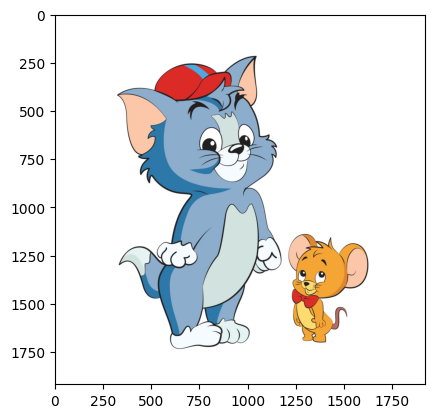

torch.Size([3, 1919, 1920])

In [ ]:
# Load image and normalize
img_path = '/content/tom-and-jerry-cartoon.jpg'  # Update this path as needed
img = torchvision.io.read_image(img_path).float() / 255.0  # Normalize between 0 and 1
plt.imshow(img.permute(1, 2, 0))
# plt.axis('off')
plt.show()
img.shape


In [ ]:
crop = torchvision.transforms.functional.crop(img, 1250, 1250, 300, 300)
crop.shape

torch.Size([3, 300, 300])

In [ ]:
img = crop.permute(1, 2, 0)  # Change shape to (height, width, channels)
img.shape

torch.Size([300, 300, 3])

In [ ]:
def mask_image(img, num_masked_pixels):
    height, width, _ = img.shape
    mask = np.ones((height, width), dtype=bool)
    masked_indices = np.random.choice(height * width, num_masked_pixels, replace=False)
    mask.flat[masked_indices] = False
    img_copy = img.copy()
    img_copy[~mask] = np.nan  # Set 900 masked pixels to NaN
    return img_copy, mask

In [ ]:
masked_image, mask = mask_image(img.numpy(), 900)

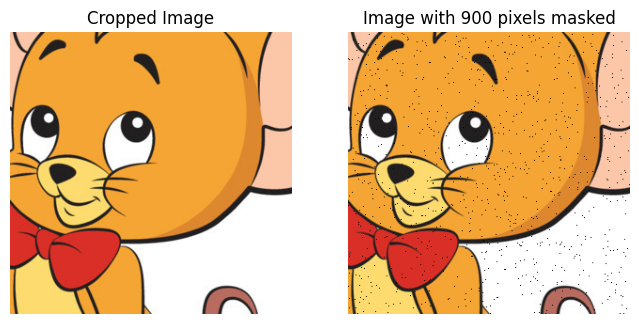

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Cropped Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.where(np.isnan(masked_image), np.zeros_like(masked_image), masked_image)) # Show NaNs as black
plt.title("Image with 900 pixels masked")
plt.axis('off')
plt.show()

In [ ]:
print(masked_image.shape)

(300, 300, 3)


In [ ]:
def coordinate_matrix(masked_image):
    height, width, _ = masked_image.shape
    unmasked_indices = np.argwhere(~np.isnan(masked_image))
    unmasked_values = masked_image[~np.isnan(masked_image)].reshape(-1, 3)

    # Create coordinate map for known pixels
    X_true = unmasked_indices.astype(float)

    return X_true, unmasked_values

X_true, y_true = coordinate_matrix(masked_image)

In [ ]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

X_rff = create_rff_features(X_true, 900, 3)

In [ ]:
print(X_rff.shape)
print(y_true.shape)

torch.Size([267300, 900])
(89100, 3)


In [ ]:
# Check if lengths are consistent before fitting the model
if len(X_rff) != len(y_true):
    print("Warning: The number of samples in RFF features and known values do not match!")

    # Aligning shapes by truncating y_known
    min_length = min(len(X_rff), len(y_true))

    X_rff = X_rff[:min_length]
    y_known = y_true[:min_length]

In [ ]:
print(X_rff.shape)
print(y_true.shape)

torch.Size([89100, 900])
(89100, 3)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        Y = torch.tensor(Y, dtype=torch.float32)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

net = LinearModel(X_rff.shape[1], 3)    #same as 2, 3 only


train(net, 0.004, X_rff, y_true, 1000)

Epoch 0 loss: 0.541704


<ipython-input-80-ca8513882477>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


Epoch 100 loss: 0.153590
Epoch 200 loss: 0.058642
Epoch 300 loss: 0.038610
Epoch 400 loss: 0.034506
Epoch 500 loss: 0.033367
Epoch 600 loss: 0.032871
Epoch 700 loss: 0.032590
Epoch 800 loss: 0.032412
Epoch 900 loss: 0.032289


0.03220051899552345

In [ ]:
masked_indices = np.argwhere(np.isnan(masked_image))
X_missing_rff = create_rff_features(masked_indices.astype(float), 900, 3)

In [ ]:
predicted_values = net(X_missing_rff)

In [ ]:
reconstructed_image = masked_image.copy()
reconstructed_image[masked_indices[:, 0], masked_indices[:, 1]] = predicted_values.detach().numpy()

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


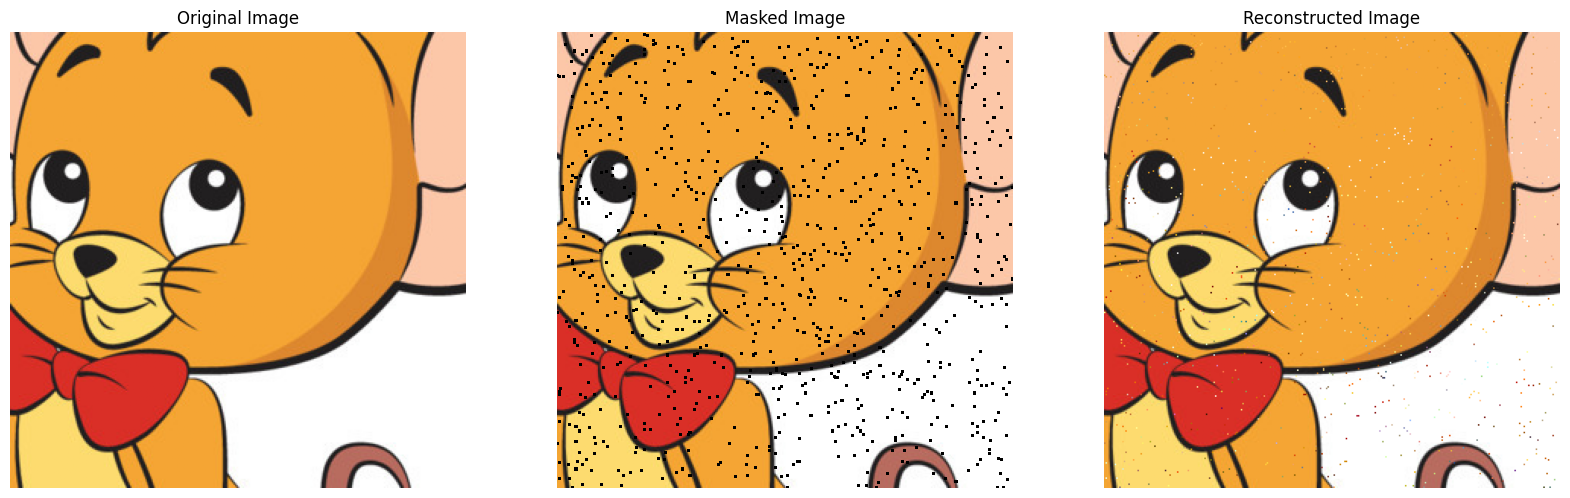

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masked_image)
plt.title("Masked Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()

In [ ]:
def compute_rmse(tensor1, tensor2):
    # Convert NumPy arrays to PyTorch tensors
    if not isinstance(tensor1, torch.Tensor):
        tensor1 = torch.from_numpy(tensor1)
    if not isinstance(tensor2, torch.Tensor):
        tensor2 = torch.from_numpy(tensor2)

    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    # Convert NumPy arrays to PyTorch tensors
    if not isinstance(tensor1, torch.Tensor):
        tensor1 = torch.from_numpy(tensor1)
    if not isinstance(tensor2, torch.Tensor):
        tensor2 = torch.from_numpy(tensor2)

    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()

rmse = compute_rmse(reconstructed_image, img)
psnr = compute_psnr(reconstructed_image, img)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")

RMSE: 0.03852646425366402
PSNR: 28.28481674194336


1. RMSE using random fourier features with linear regression: 0.03852646425366402
- PSNR using random fourier features with linear regression: 28.28481674194336
2. RMSE using matrix factorization : 0.0974
- PSNR using matrix factorization : 20.23 dB

### Random fourier features with linear regression works better than matrix factorization.